<p align="center">
  <img src="../data/uach.png" alt="UACh" width="180">
</p>

# Hito 2 ‚Äî Prototipo de Convoluci√≥n

Proyecto ACUS220 ¬∑ Ac√∫stica Computacional con Python

Este notebook implementa un prototipo funcional para auralizaci√≥n por convoluci√≥n con una librer√≠a de presets de respuestas al impulso (IR). Permite generar una se√±al de entrada (o cargar una), seleccionar una IR (salas y un modelo escalonado tipo ‚ÄòQuetzal‚Äô), aplicar filtros simples y escuchar/visualizar el resultado, adem√°s de exportar a WAV.

**Integrantes:** Carlos Duarte, Fernando Castillo, Vicente Alves, Antonio Duque

## 1. Introducci√≥n

### 1.1 Problema

El fen√≥meno ac√∫stico observado en la Pir√°mide de Kukulk√°n en Chich√©n Itz√°, M√©xico, constituye un caso √∫nico de transformaci√≥n del sonido debido a la geometr√≠a arquitect√≥nica. Cuando se produce un aplauso frente a la escalinata de la pir√°mide, el eco resultante adquiere un car√°cter tonal que asemeja el canto del ave quetzal, sagrada para la cultura maya.

Este efecto, conocido como "chirp" o "eco del quetzal", es producto de las reflexiones secuenciales en los escalones de la pir√°mide. Cada escal√≥n act√∫a como una fuente secundaria que introduce un retardo temporal espec√≠fico, generando una serie de reflexiones con espaciamiento regular que modula el contenido espectral del impulso original.

**Problem√°tica principal:**  
- ¬øC√≥mo podemos modelar y replicar este fen√≥meno mediante procesamiento digital de se√±ales?  
- ¬øQu√© caracter√≠sticas de la se√±al de entrada y la respuesta al impulso son determinantes para reproducir el efecto?  
- ¬øEs posible dise√±ar estructuras sint√©ticas que generen transformaciones ac√∫sticas similares?

### 1.2 Herramienta de convoluci√≥n

La **convoluci√≥n** es la operaci√≥n matem√°tica fundamental para el an√°lisis de sistemas lineales e invariantes en el tiempo (LTI). En el contexto ac√∫stico, permite calcular la salida de un sistema cuando conocemos:

- **x(t)**: Se√±al de entrada (por ejemplo, un aplauso)  
- **h(t)**: Respuesta al impulso (IR) del sistema (caracter√≠sticas ac√∫sticas del espacio)

La salida del sistema se obtiene mediante:

$$ y(t) = x(t) * h(t) = \int_{-\infty}^{\infty} x(\tau) \cdot h(t-\tau) \, d\tau $$

En el dominio discreto (procesamiento digital):

$$ y[n] = \sum_{k=-\infty}^{\infty} x[k] \cdot h[n-k] $$

**Implementaci√≥n pr√°ctica:**  
Para se√±ales de duraci√≥n finita, es m√°s eficiente usar la **FFT (Fast Fourier Transform)** y el teorema de convoluci√≥n:

$$ y(t) = x(t) * h(t) \quad \Leftrightarrow \quad Y(f) = X(f) \cdot H(f) $$

Donde el producto en el dominio de la frecuencia equivale a la convoluci√≥n en el dominio del tiempo.

### 1.3 Objetivos de este an√°lisis

**Objetivo General:**  
Desarrollar e implementar un prototipo funcional de auralizaci√≥n por convoluci√≥n que permita simular el efecto ac√∫stico de la Pir√°mide de Chich√©n Itz√° y otros espacios de inter√©s.

**Objetivos Espec√≠ficos:**

1. **OE1 - Implementaci√≥n:** Desarrollar funciones en Python para:
   - Generar se√±ales de prueba (aplauso sint√©tico, barridos senoidales)
   - Cargar y procesar respuestas al impulso
   - Aplicar convoluci√≥n FFT con normalizaci√≥n
   - Implementar filtros b√°sicos (pasa-bajos, pasa-altos, pasa-banda)

2. **OE2 - An√°lisis:** Caracterizar las se√±ales mediante:
   - Visualizaci√≥n de formas de onda
   - An√°lisis espectral (espectrogramas, espectro de magnitud)
   - M√©tricas temporales y frecuenciales

3. **OE3 - Modelado:** Crear una librer√≠a de respuestas al impulso:
   - Salas de diferentes tama√±os (peque√±a, mediana, grande)
   - Modelo sint√©tico de estructura escalonada (simulaci√≥n pir√°mide)
   - Utilizar pyroomacoustics para simulaci√≥n de espacios

4. **OE4 - Validaci√≥n:** Comparar resultados simulados con:
   - Grabaciones de referencia
   - An√°lisis perceptual del efecto generado
   - Discusi√≥n de limitaciones f√≠sicas del modelo

## 2. An√°lisis preliminar

### 2.1 Generaci√≥n de se√±ales de prueba

Para evaluar el comportamiento de las respuestas al impulso, generamos tres tipos de se√±ales de entrada:

1. **Aplauso sint√©tico**: Se√±al impulsiva que simula un aplauso mediante ruido blanco con envolvente exponencial. Es la se√±al m√°s representativa para este estudio, ya que el fen√≥meno original se produce con aplausos.

2. **Barrido senoidal (chirp)**: Se√±al que var√≠a linealmente en frecuencia de 20 Hz a 12 kHz. √ötil para analizar la respuesta del sistema en todo el rango audible.

3. **Audio personalizado**: Posibilidad de cargar archivos WAV externos para experimentar con diferentes fuentes sonoras.

A continuaci√≥n, generamos y visualizamos un aplauso sint√©tico para caracterizar sus propiedades:


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import librosa
import librosa.display
from IPython.display import Audio, display

In [35]:
# Funci√≥n para generar aplauso sint√©tico
def make_synthetic_clap(sr=48000, duration=0.5):
    """
    Genera un aplauso sint√©tico breve simulando un pulso aleatorio amortiguado.
    """
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    # Pulso tipo ruido blanco modulado exponencialmente
    clap = np.random.randn(len(t)) * np.exp(-10 * t)
    # Normalizar
    clap /= np.max(np.abs(clap))
    return clap


# Graficar forma de onda
def plot_waveform(signal, sr, title='Forma de onda'):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(title)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.show()

# Graficar espectrograma
def plot_spectrogram(signal, sr, title='Espectrograma'):
    S = np.abs(librosa.stft(signal))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

Se√±al de prueba: Aplauso sint√©tico


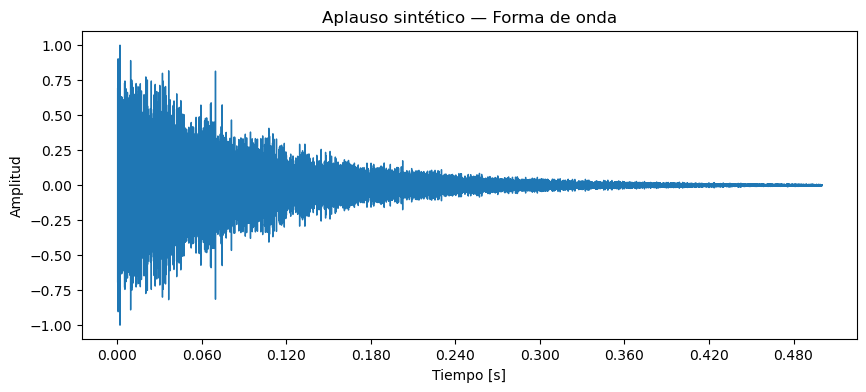

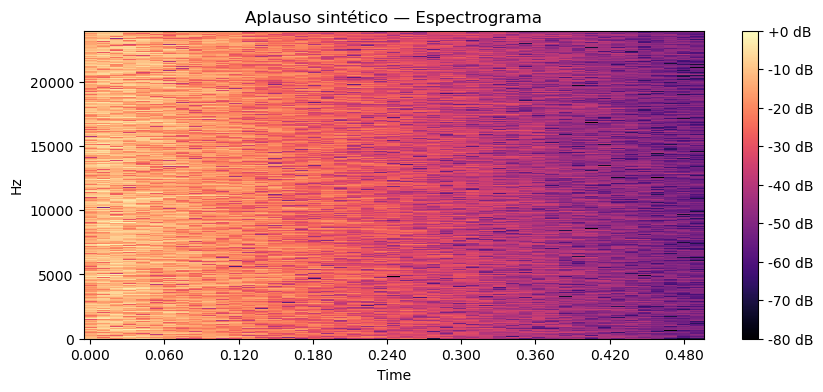

In [36]:
# Generar un aplauso sint√©tico para an√°lisis
sr = 48000  # Frecuencia de muestreo
clap = make_synthetic_clap(sr=sr)

# Reproducir audio
print("Se√±al de prueba: Aplauso sint√©tico")
display(Audio(clap, rate=sr))  # ‚Üê bot√≥n Play en Jupyter


# Visualizar forma de onda
plot_waveform(clap, sr, title='Aplauso sint√©tico ‚Äî Forma de onda')

# Visualizar espectrograma
plot_spectrogram(clap, sr, title='Aplauso sint√©tico ‚Äî Espectrograma')

### 2.2 Caracter√≠sticas de la se√±al

El an√°lisis de las caracter√≠sticas temporales y espectrales de la se√±al de entrada es fundamental para entender c√≥mo ser√° transformada por la respuesta al impulso del espacio ac√∫stico.

**Par√°metros temporales:**
- **Duraci√≥n total**: Determinada por la envolvente exponencial 
- **Tiempo de ataque**: Muy corto (~1 ms), caracter√≠stico de se√±ales impulsivas
- **Tiempo de decaimiento**: Modelado por la constante exponencial (œÑ ‚âà 0.05 s)

**Par√°metros espectrales:**
- **Contenido de banda ancha**: El aplauso sint√©tico contiene energ√≠a en todo el espectro audible (20 Hz - 20 kHz)
- **Densidad espectral**: Aproximadamente plana 
- **Picos espectrales**: La estructura escalonada de la pir√°mide generar√° realces en frecuencias espec√≠ficas relacionadas con el espaciamiento de los escalones

**C√°lculo de caracter√≠sticas:**


Duraci√≥n de la se√±al: 0.5000 segundos (24000 muestras)
Amplitud m√°xima: 1.0000
RMS (energ√≠a): 0.1034
Frecuencia con mayor energ√≠a: 18351.56 Hz


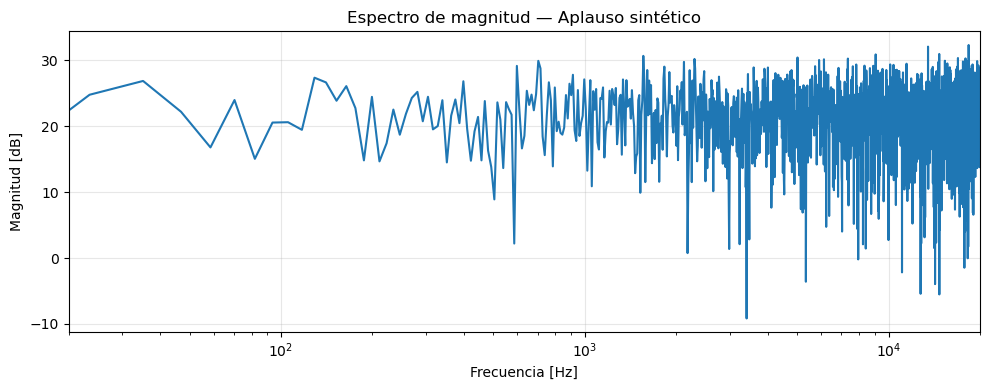

Ancho de banda efectivo (-20 dB): 0 Hz - 24000 Hz


In [37]:
# An√°lisis de caracter√≠sticas de la se√±al
import numpy as np
from scipy import signal as sp_signal

# Duraci√≥n
duration_sec = len(clap) / sr
print(f"Duraci√≥n de la se√±al: {duration_sec:.4f} segundos ({len(clap)} muestras)")

# Amplitud m√°xima y RMS
max_amp = np.max(np.abs(clap))
rms = np.sqrt(np.mean(clap**2))
print(f"Amplitud m√°xima: {max_amp:.4f}")
print(f"RMS (energ√≠a): {rms:.4f}")

# Espectro de magnitud
n_fft = 4096
freqs = np.fft.rfftfreq(n_fft, 1/sr)
spectrum = np.abs(np.fft.rfft(clap, n=n_fft))

# Frecuencia dominante
peak_idx = np.argmax(spectrum)
peak_freq = freqs[peak_idx]
print(f"Frecuencia con mayor energ√≠a: {peak_freq:.2f} Hz")

# Graficar espectro de magnitud
plt.figure(figsize=(10, 4))
plt.plot(freqs, 20*np.log10(spectrum + 1e-10))  # Convertir a dB
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de magnitud ‚Äî Aplauso sint√©tico')
plt.xlim(20, 20000)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ancho de banda efectivo (donde la energ√≠a es >-20 dB del m√°ximo)
threshold = np.max(spectrum) * 0.1  # -20 dB
indices_above = np.where(spectrum > threshold)[0]
if len(indices_above) > 0:
    f_low = freqs[indices_above[0]]
    f_high = freqs[indices_above[-1]]
    print(f"Ancho de banda efectivo (-20 dB): {f_low:.0f} Hz - {f_high:.0f} Hz")

## 3. Respuesta al impulso (IR)

### 3.1 ¬øQu√© es IR?

La **Respuesta al Impulso** (IR, del ingl√©s *Impulse Response*) es la salida de un sistema cuando se excita con un impulso unitario (delta de Dirac). En ac√∫stica, representa la caracterizaci√≥n completa de un espacio o sistema ac√∫stico lineal.

**Propiedades clave:**

1. **Caracterizaci√≥n completa del sistema**: La IR contiene toda la informaci√≥n sobre c√≥mo el sistema responde a cualquier entrada.

2. **Informaci√≥n temporal**: 
   - **Sonido directo**: Primera llegada, sin reflexiones
   - **Reflexiones tempranas**: Primeras reflexiones en superficies (< 80 ms)
   - **Reverberaci√≥n tard√≠a**: Cola de decaimiento exponencial

3. **Informaci√≥n espectral**: La IR codifica c√≥mo el espacio modifica cada frecuencia de manera diferente (absorci√≥n dependiente de frecuencia, resonancias, etc.).

**Tipos de IR en este proyecto:**

- **IR de salas simuladas** (pyroomacoustics):
  - Sala peque√±a: 5√ó4√ó3 m, RT60 ‚âà 0.3 s
  - Sala mediana: 10√ó8√ó4 m, RT60 ‚âà 0.5 s  
  - Sala grande/Hall: 20√ó15√ó8 m, RT60 ‚âà 1.2 s

- **IR de estructura escalonada** (modelo Pir√°mide/Quetzal):
  - Simulaci√≥n de reflexiones en escalones peri√≥dicos
  - Genera el efecto "chirp" caracter√≠stico
  - Basado en el trabajo de Declercq et al. [1,2]



### 3.2 ¬øQu√© es la convoluci√≥n?

La **convoluci√≥n** es la operaci√≥n matem√°tica que combina dos se√±ales para producir una tercera. En el contexto de la auralizaci√≥n ac√∫stica:

$$
\text{Se√±al auralizada} = \text{Se√±al seca} * \text{Respuesta al impulso}
$$

**Interpretaci√≥n f√≠sica:**

Cuando una se√±al **x[n]** (por ejemplo, un aplauso) se propaga en un espacio con IR **h[n]**, cada muestra de **x[n]** genera una copia escalada de **h[n]**. La salida **y[n]** es la superposici√≥n de todas estas copias retardadas:

$$
y[n] = \sum_{k=0}^{N-1} x[k] \cdot h[n-k]
$$


**Aplicaciones en este proyecto:**

1. **Auralizaci√≥n**: Simular c√≥mo sonar√≠a una fuente en un espacio espec√≠fico
2. **An√°lisis de espacios**: Entender caracter√≠sticas ac√∫sticas mediante visualizaci√≥n de IR
3. **Validaci√≥n del modelo**: Comparar audio simulado con grabaciones reales
4. **Dise√±o ac√∫stico**: Experimentar con diferentes geometr√≠as y materiales

**Consideraciones pr√°cticas:**

- **Normalizaci√≥n**: Es crucial normalizar la salida para evitar clipping (saturaci√≥n digital)
- **Longitud de la convoluci√≥n**: Si x[n] tiene longitud N y h[n] tiene longitud M, y[n] tendr√° longitud N+M-1
- **Causalidad**: Las IR deben ser causales (h[n] = 0 para n < 0)
- **Filtrado adicional**: Se pueden aplicar filtros (EQ) antes o despu√©s de la convoluci√≥n para ajustar el timbre

## 4. Implementaci√≥n de la convoluci√≥n

### 4.1 Importar Librer√≠as y M√≥dulos

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import importlib

In [39]:
# Agregar la carpeta src al path de Python
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Importar m√≥dulos personalizados
from audio_utils import (
    make_synthetic_clap,
    convolve_fft,
    play_audio, 
    save_audio,
    calculate_rms,
    calculate_peak
)

from ir_generator import (
    generate_preset_rooms,
    calculate_rt60
)

from visualization import (
    plot_waveform,
    plot_spectrogram,
    plot_comparison_waveforms,
    plot_comparison_spectrograms,
    plot_edc
)


Se√±al de prueba: Aplauso sint√©tico


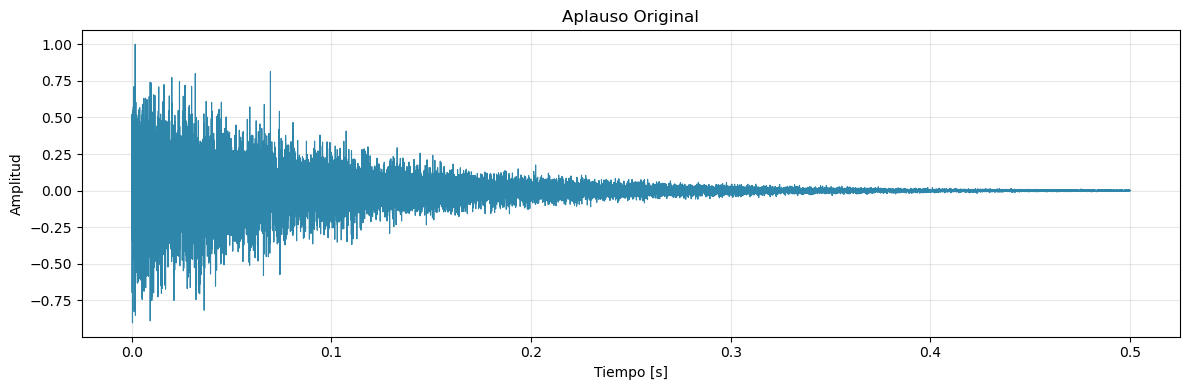

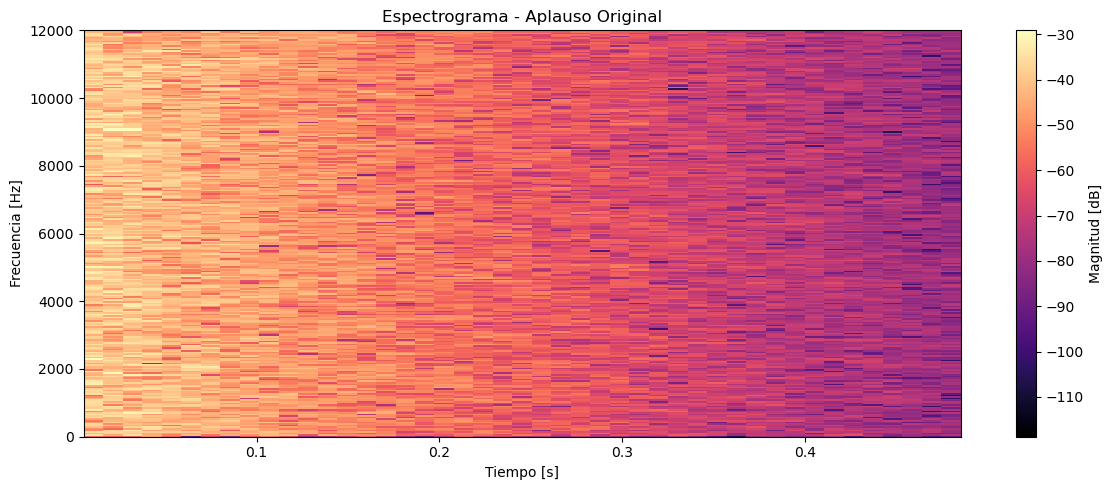

In [40]:
# Reproducir audio origial
print("Se√±al de prueba: Aplauso sint√©tico")
play_audio(clap, sr)

plot_waveform(clap, sr, title='Aplauso Original', color='#2E86AB')
plot_spectrogram(clap, sr, title='Espectrograma - Aplauso Original')

### 4.2 Generar Respuestas al Impulso

In [41]:
print("\n" + "="*60)
print("GENERANDO RESPUESTAS AL IMPULSO")
print("="*60 + "\n")

irs, metadata = generate_preset_rooms(sr=sr)

# Mostrar informaci√≥n
print("="*60)
print("INFORMACI√ìN DE LAS SALAS")
print("="*60)
for key, meta in metadata.items():
    ir = irs[key]
    rt60 = calculate_rt60(ir, sr)
    print(f"{meta['nombre']:<25} | {meta['dimensiones']:<12} | "
          f"Vol: {meta['volumen']:>5} m¬≥ | RT60: {rt60:.3f}s")
print("="*60 + "\n")


GENERANDO RESPUESTAS AL IMPULSO

Generando IR: Sala Peque√±a...
Generando IR: Sala Mediana...
Generando IR: Sala Grande (Hall)...
‚úì IRs generadas correctamente

INFORMACI√ìN DE LAS SALAS
Sala Peque√±a              | 5√ó4√ó3 m      | Vol:    60 m¬≥ | RT60: 0.000s
Sala Mediana              | 10√ó8√ó4 m     | Vol:   320 m¬≥ | RT60: 0.000s
Sala Grande / Hall        | 20√ó15√ó8 m    | Vol:  2400 m¬≥ | RT60: 0.000s



### 4.3 Aplicar Convoluci√≥n

In [42]:
print("="*60)
print("APLICANDO CONVOLUCI√ìN")
print("="*60 + "\n")

resultados = {}

for key in irs.keys():
    nombre = metadata[key]['nombre']
    print(f"Convolando: Aplauso + {nombre}...")
    resultados[key] = convolve_fft(clap, irs[key], normalize=True)
    print(f"  ‚Üí Duraci√≥n salida: {len(resultados[key])/sr:.3f}s\n")

print("‚úì Convoluciones completadas\n")

APLICANDO CONVOLUCI√ìN

Convolando: Aplauso + Sala Peque√±a...
  ‚Üí Duraci√≥n salida: 1.700s

Convolando: Aplauso + Sala Mediana...
  ‚Üí Duraci√≥n salida: 2.000s

Convolando: Aplauso + Sala Grande / Hall...
  ‚Üí Duraci√≥n salida: 2.500s

‚úì Convoluciones completadas



### 4.4 Visualizaci√≥n Individual

RESULTADO: SALA PEQUE√ëA

üîä Reproducir: Aplauso en Sala Peque√±a


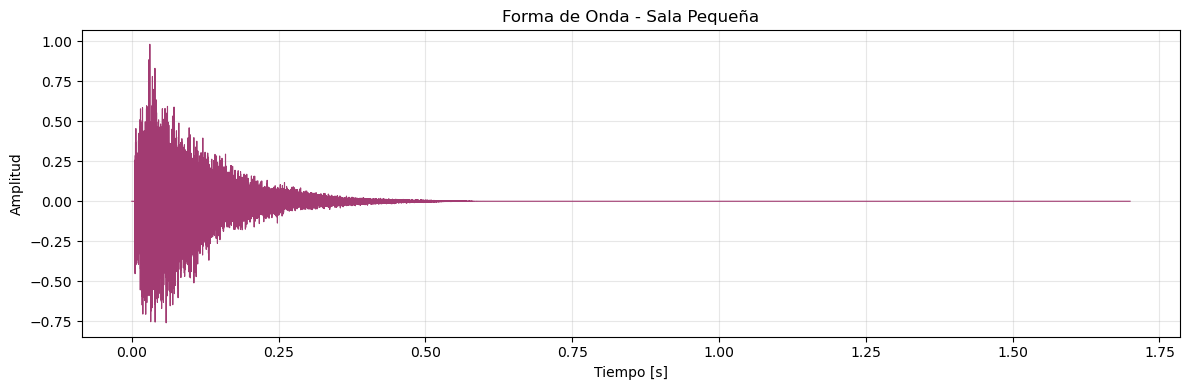

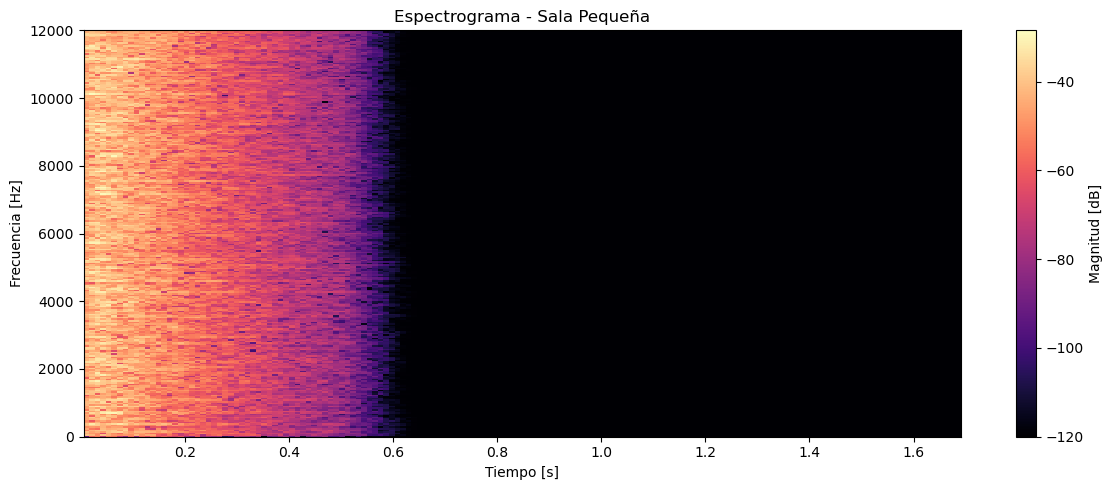

RESULTADO: SALA MEDIANA

üîä Reproducir: Aplauso en Sala Mediana


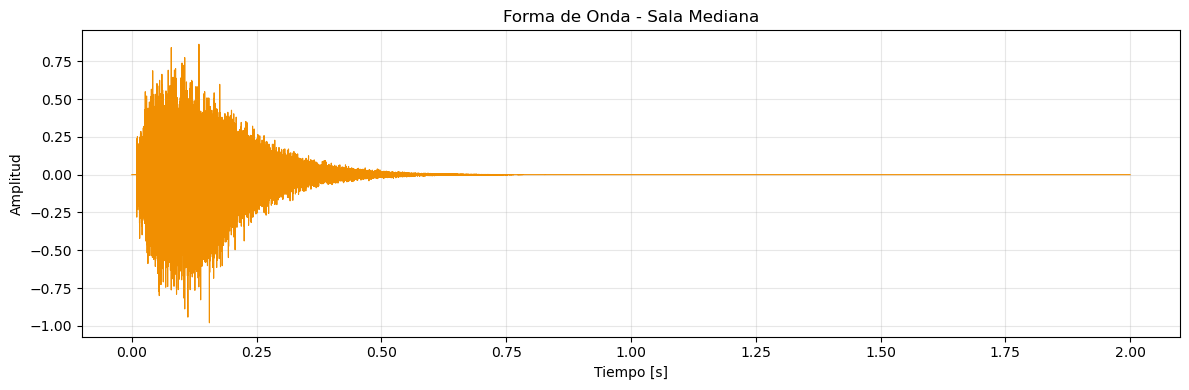

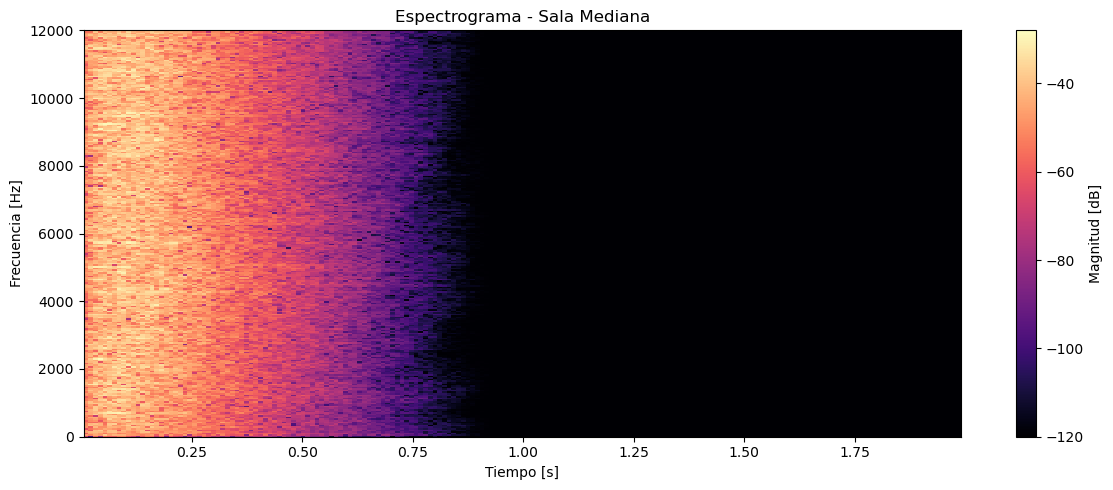

RESULTADO: SALA GRANDE / HALL

üîä Reproducir: Aplauso en Sala Grande / Hall


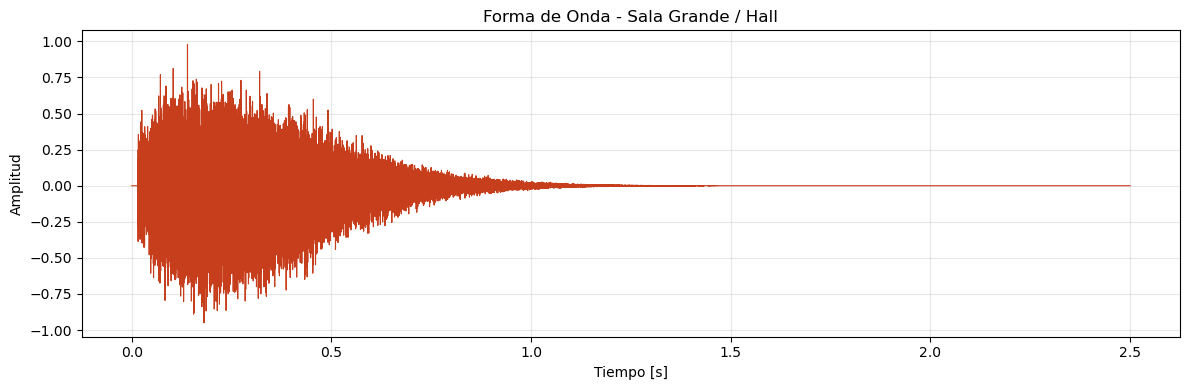

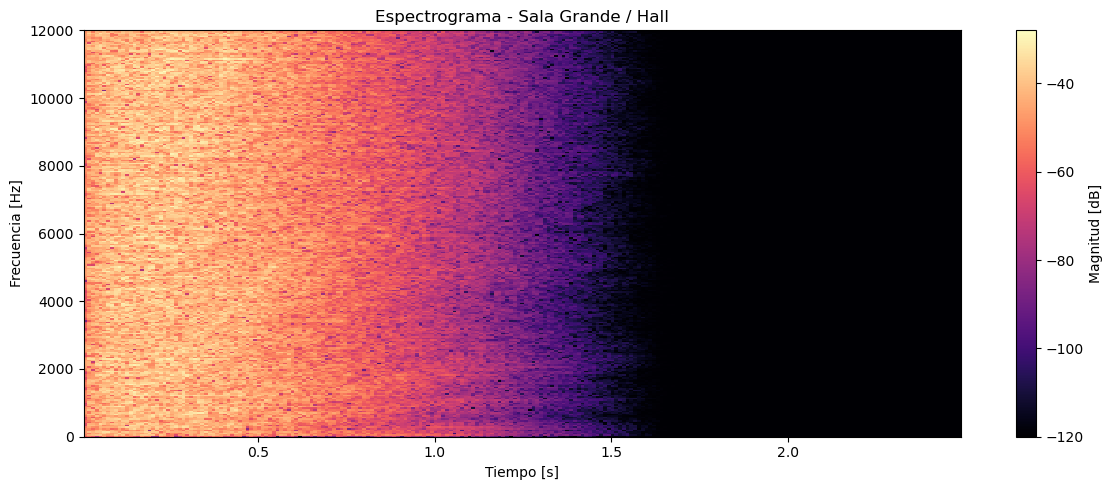

In [43]:
# Reproducir y visualizar cada resultado
for key in resultados.keys():
    nombre = metadata[key]['nombre']
    audio = resultados[key]
    color = metadata[key]['color']
    
    print("="*60)
    print(f"RESULTADO: {nombre.upper()}")
    print("="*60 + "\n")
    
    print(f"üîä Reproducir: Aplauso en {nombre}")
    play_audio(audio, sr)
    
    plot_waveform(audio, sr, title=f'Forma de Onda - {nombre}', color=color)
    plot_spectrogram(audio, sr, title=f'Espectrograma - {nombre}')

### 4.5 Comparaci√≥n Visual


COMPARACI√ìN: FORMAS DE ONDA



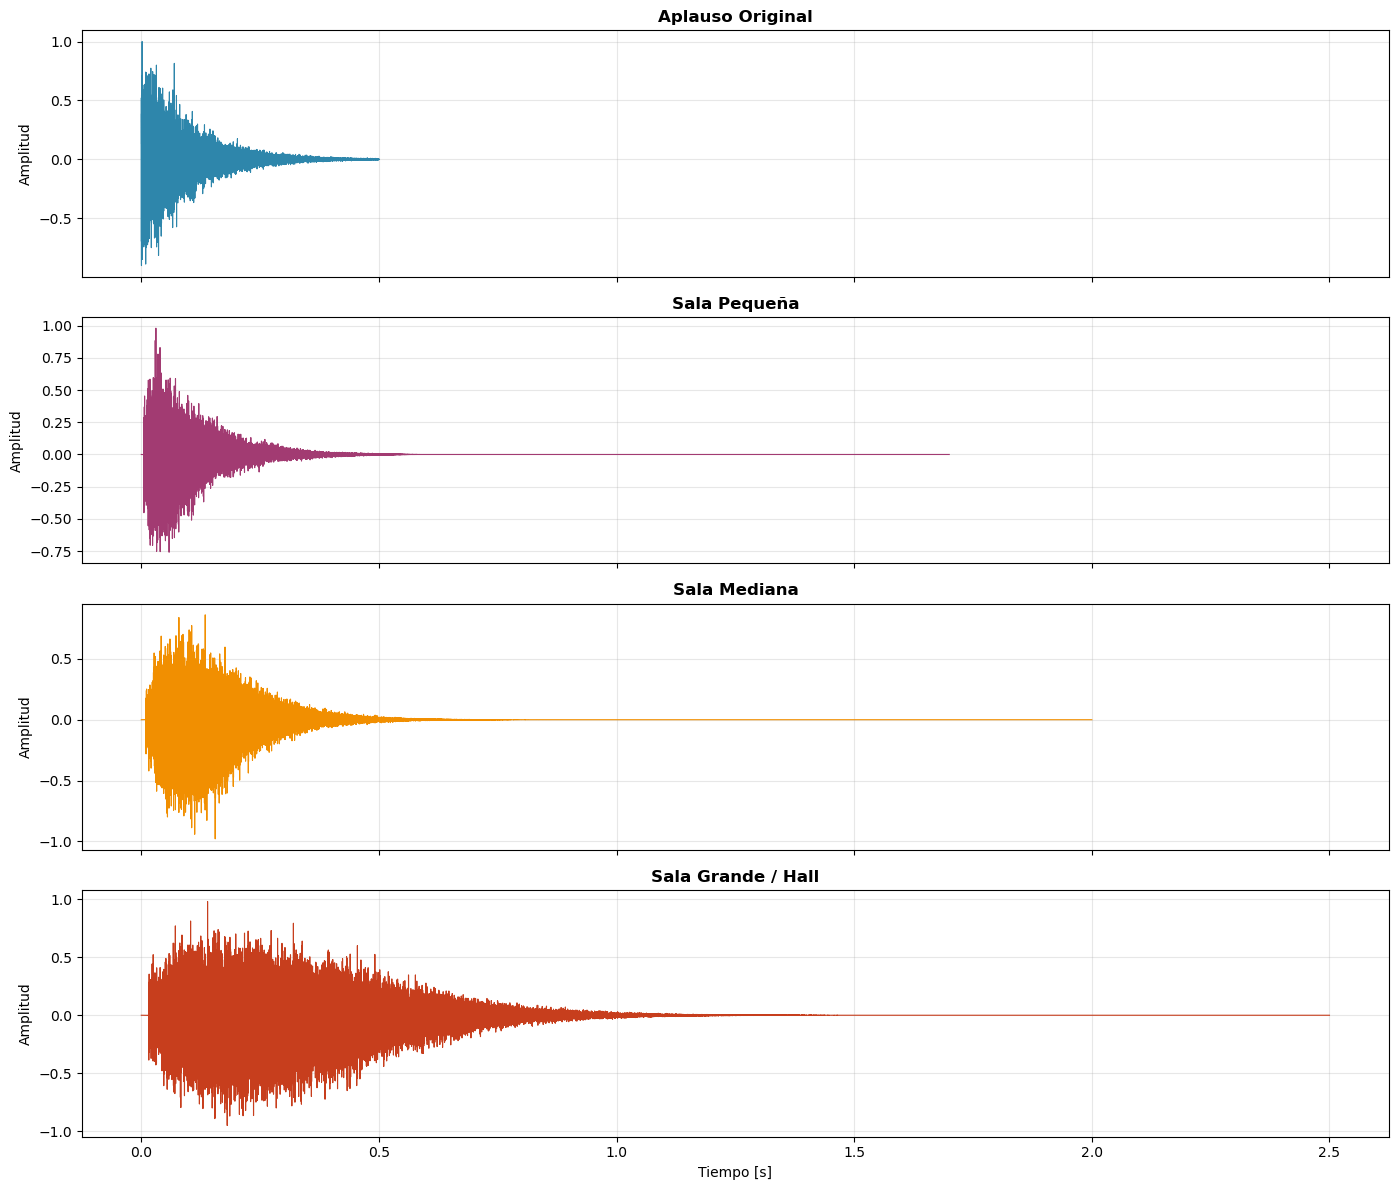

COMPARACI√ìN: ESPECTROGRAMAS



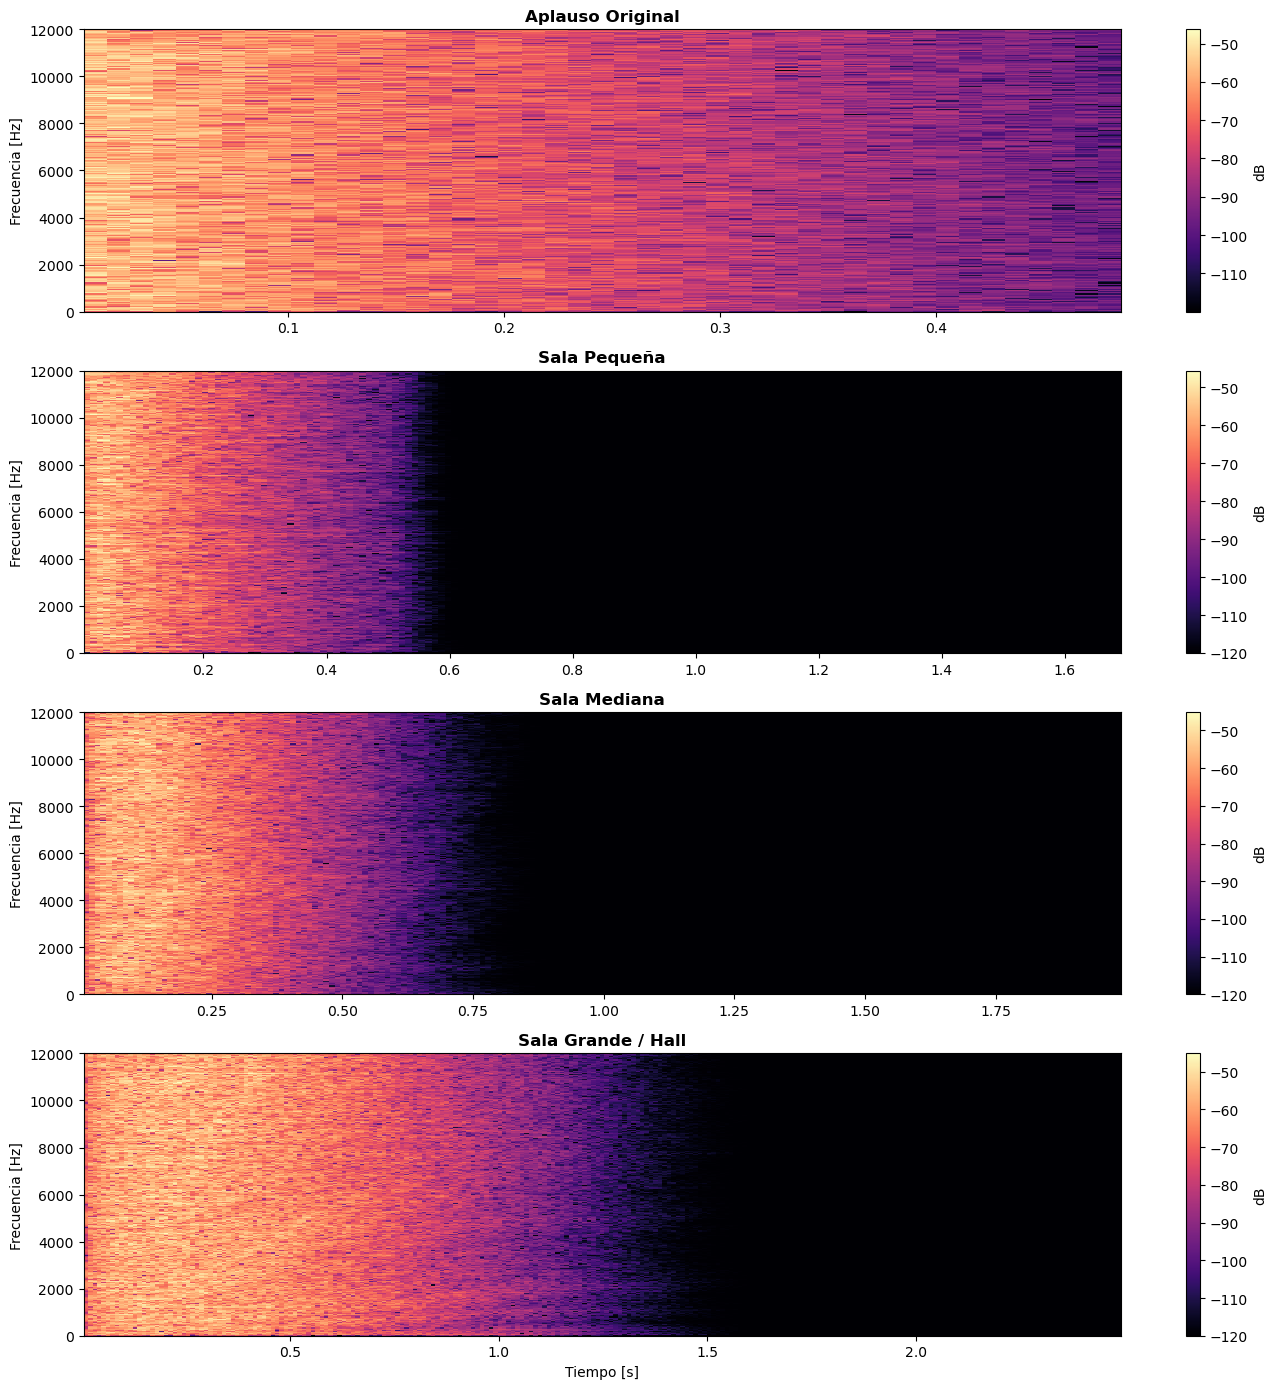

In [44]:
print("\n" + "="*60)
print("COMPARACI√ìN: FORMAS DE ONDA")
print("="*60 + "\n")

# Preparar datos para comparaci√≥n
signals = {'Aplauso Original': clap}
colors = {'Aplauso Original': '#2E86AB'}

for key in resultados.keys():
    nombre = metadata[key]['nombre']
    signals[nombre] = resultados[key]
    colors[nombre] = metadata[key]['color']

plot_comparison_waveforms(signals, sr, colors)

# %%
print("="*60)
print("COMPARACI√ìN: ESPECTROGRAMAS")
print("="*60 + "\n")

plot_comparison_spectrograms(signals, sr)

## Implementaci√≥n p≈ïactica

## Qu√© hace este prototipo
- Entradas: aplauso sint√©tico, barrido senoidal o cargar WAV.
- Presets de IR: salas (peque√±a/mediana/gran sala) y un modelo escalonado ‚ÄòPir√°mide (Quetzal)‚Äô.
- Procesamiento: convoluci√≥n FFT + normalizaci√≥n opcional + filtro simple (lowpass/highpass/bandpass).
- Salida: reproductor de audio, forma de onda, espectrograma y opci√≥n de exportar WAV a `hito2/data/outputs/`.

In [14]:
import os, time, math, textwrap
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
import ipywidgets as widgets
from IPython.display import Audio, display, clear_output
import pyroomacoustics as pra

plt.rcParams['figure.figsize'] = (10, 4)
DATA_DIR = Path('data')
IN_DIR = DATA_DIR / 'inputs'
OUT_DIR = DATA_DIR / 'outputs'
IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Entorno listo.')


Entorno listo.


In [15]:
# Utilidades de audio y visualizaci√≥n
def normalize_audio(x, peak=0.98):
    x = np.asarray(x, dtype=float)
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * peak

def resample_if_needed(x, sr, target_sr):
    if target_sr is None or sr == target_sr:
        return x, sr
    g = math.gcd(int(sr), int(target_sr))
    up = target_sr // g
    down = sr // g
    xr = signal.resample_poly(x, up, down)
    return xr.astype(float), target_sr

def load_audio(path, target_sr=None, mono=True):
    x, sr = sf.read(path, always_2d=False)
    if x.ndim > 1 and mono:
        x = x.mean(axis=1)
    x, sr = resample_if_needed(x, sr, target_sr)
    return x.astype(float), sr

def save_audio(path, x, sr):
    sf.write(str(path), x, int(sr))

def plot_waveform(x, sr, title='Se√±al'):
    t = np.arange(len(x)) / sr
    plt.figure()
    plt.plot(t, x, lw=0.9)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(x, sr, title='Espectrograma'):
    f, t, Sxx = signal.spectrogram(x, fs=sr, nperseg=1024, noverlap=512, scaling='spectrum')
    Sxx_db = 10 * np.log10(Sxx + 1e-12)
    plt.figure()
    plt.pcolormesh(t, f, Sxx_db, shading='auto', cmap='magma')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.ylim(0, sr/2)
    plt.title(title)
    plt.colorbar(label='dB')
    plt.tight_layout()
    plt.show()

def play(x, sr):
    display(Audio(x, rate=sr))

def make_synthetic_clap(sr=48000, duration_s=0.12, decay=3.5, noise_level=0.3):
    n = int(sr * duration_s)
    x = np.zeros(n)
    x[0] = 1.0  # impulso inicial
    rn = np.random.randn(n)
    env = np.exp(-np.linspace(0, decay, n))
    x += noise_level * rn * env
    return normalize_audio(x)

def make_sine_sweep(sr=48000, dur_s=2.0, f0=20.0, f1=12000.0):
    t = np.linspace(0, dur_s, int(sr*dur_s), endpoint=False)
    x = signal.chirp(t, f0=f0, f1=f1, t1=dur_s, method='logarithmic')
    win = signal.windows.tukey(len(x), alpha=0.1)
    return normalize_audio(x*win)

def butter_filter(x, sr, ftype='none', f_lo=200.0, f_hi=3000.0, order=4):
    x = np.asarray(x, dtype=float)
    nyq = 0.5 * sr
    f_lo = max(10.0, min(f_lo, nyq*0.99))
    f_hi = max(20.0, min(f_hi, nyq*0.99))
    if ftype == 'none':
        return x
    if ftype == 'lowpass':
        wn = min(f_hi/nyq, 0.999)
        b, a = signal.butter(order, wn, btype='low', output='ba')
    elif ftype == 'highpass':
        wn = max(f_lo/nyq, 1e-4)
        b, a = signal.butter(order, wn, btype='high', output='ba')
    elif ftype == 'bandpass':
        lo = max(1e-4, min(f_lo/nyq, 0.99))
        hi = max(lo*1.01, min(f_hi/nyq, 0.999))
        b, a = signal.butter(order, [lo, hi], btype='band', output='ba')
    else:
        return x
    return signal.lfilter(b, a, x)

def apply_ir(x, ir, normalize=True):
    y = signal.fftconvolve(x, ir, mode='full')
    return normalize_audio(y) if normalize else y


In [16]:
# Generaci√≥n de IRs: sala (Pyroomacoustics) y estructura escalonada (‚ÄòQuetzal‚Äô)
def pad_to_length(x, n):
    if len(x) >= n:
        return x[:n]
    out = np.zeros(n)
    out[:len(x)] = x
    return out

def simulate_room_ir(
    sr=48000,
    room_dim=(8.0, 5.0, 3.0),
    absorption=0.2,
    max_order=10,
    src_pos=(2.0, 2.0, 1.5),
    mic_pos=(6.0, 3.0, 1.5),
    ir_length_s=1.2,
):
    materials = pra.Material(absorption)
    room = pra.ShoeBox(room_dim, fs=sr, materials=materials, max_order=max_order)
    room.add_source(src_pos)
    mic_locs = np.array(mic_pos).reshape(-1, 1)
    room.add_microphone_array(pra.MicrophoneArray(mic_locs, room.fs))
    room.compute_rir()
    ir = np.asarray(room.rir[0][0], dtype=float)
    N = int(sr * ir_length_s)
    ir = pad_to_length(ir, N)
    return normalize_audio(ir)

def stepped_structure_ir(
    sr=48000,
    base_delay_ms=6.0,   # primer retardo
    step_delta_ms=1.2,   # incremento de retardo por eco
    accel_ms=-0.03,      # curvatura temporal (chirp en tiempos)
    num_steps=45,        # cantidad de ecos
    decay=0.92,          # atenuaci√≥n por paso
    ir_length_s=1.4,
):
    delays_ms = []
    for n in range(num_steps):
        t = base_delay_ms + n * step_delta_ms + 0.5 * accel_ms * n * (n - 1)
        if t >= 0:
            delays_ms.append(t)
    if not delays_ms:
        return np.array([1.0])
    max_delay_ms = max(delays_ms)
    N = int(sr * ir_length_s)
    L = max(N, int(sr * (max_delay_ms / 1000.0)) + sr // 10)
    ir = np.zeros(L)
    for i, t_ms in enumerate(delays_ms):
        idx = int(round(sr * (t_ms / 1000.0)))
        if idx < L:
            ir[idx] += decay ** i
    ir[0] += 0.05
    ir = ir[:N] if N < len(ir) else ir
    return normalize_audio(ir)

def get_preset_ir(preset, sr):
    preset = str(preset).lower().strip()
    if preset.startswith('sala peque√±a'):
        ir = simulate_room_ir(sr=sr, room_dim=(4.0, 3.0, 2.5), absorption=0.45, max_order=8,
                            src_pos=(1.2,1.0,1.2), mic_pos=(3.2,1.8,1.2), ir_length_s=1.0)
        label = 'Sala peque√±a'
    elif preset.startswith('sala mediana'):
        ir = simulate_room_ir(sr=sr, room_dim=(8.0, 5.5, 3.2), absorption=0.25, max_order=12,
                            src_pos=(2.0,2.3,1.5), mic_pos=(6.0,3.1,1.5), ir_length_s=1.2)
        label = 'Sala mediana'
    elif 'hall' in preset or 'grande' in preset:
        ir = simulate_room_ir(sr=sr, room_dim=(16.0, 11.0, 6.0), absorption=0.12, max_order=15,
                            src_pos=(4.0,3.0,2.0), mic_pos=(12.0,7.0,2.5), ir_length_s=1.6)
        label = 'Sala grande / Hall'
    else:
        ir = stepped_structure_ir(sr=sr)
        label = 'Pir√°mide (Quetzal)'
    return ir, label


In [17]:
# Interfaz interactiva con ipywidgets
# Controles
sr_dd = widgets.Dropdown(options=[48000, 44100], value=48000, description='Frecuencia de muestreo')
in_src = widgets.Dropdown(
    options=['Aplauso (sint√©tico)', 'Barrido senoidal (20 Hz‚Äì12 kHz)', 'Cargar WAV (carpeta inputs)'],
    value='Aplauso (sint√©tico)', description='Entrada'
)
wav_path = widgets.Text(value=str(IN_DIR / 'mi_audio.wav'), description='Ruta WAV', layout=widgets.Layout(width='50%'))

preset_dd = widgets.Dropdown(
    options=['Sala peque√±a', 'Sala mediana', 'Sala grande / Hall', 'Pir√°mide (Quetzal) üå™Ô∏è'],
    value='Sala mediana', description='Preajuste de IR'
)

# Filtro de coloraci√≥n (post-EQ)
eq_dd = widgets.Dropdown(options=['Ninguno', 'Pasa-bajos', 'Pasa-altos', 'Pasa-banda'], value='Ninguno', description='Filtro (posterior)')
f_lo = widgets.FloatSlider(value=200.0, min=20.0, max=5000.0, step=10.0, description='Frecuencia baja [Hz]')
f_hi = widgets.FloatSlider(value=3000.0, min=200.0, max=18000.0, step=10.0, description='Frecuencia alta [Hz]')
normalize_ck = widgets.Checkbox(value=True, description='Normalizar')

render_btn = widgets.Button(description='Procesar', button_style='primary')
save_btn = widgets.Button(description='Exportar WAV', button_style='')
out = widgets.Output()

state = {'y': None, 'sr': None, 'label': None, 'busy': False}

def _slug(s):
    return ''.join(ch for ch in s.lower() if ch.isalnum() or ch in ('-', '_')).replace(' ', '_')

def do_render(_=None):
    if state.get('busy'):
        return
    state['busy'] = True
    render_btn.disabled = True
    try:
        sr = int(sr_dd.value)
        # Entrada
        if in_src.value.startswith('Aplauso'):
            x = make_synthetic_clap(sr=sr)
        elif in_src.value.startswith('Barrido senoidal'):
            x = make_sine_sweep(sr=sr)
        else:
            x, _sr = load_audio(wav_path.value, target_sr=sr)
        # IR
        ir, label = get_preset_ir(preset_dd.value, sr)
        # Convoluci√≥n
        y = apply_ir(x, ir, normalize=normalize_ck.value)
        # Post-EQ
        eq_mode = eq_dd.value.lower()
        if eq_mode != 'ninguno':
            mode_map = {'pasa-bajos': 'lowpass', 'pasa-altos': 'highpass', 'pasa-banda': 'bandpass'}
            y = butter_filter(y, sr, ftype=mode_map.get(eq_mode, 'none'), f_lo=f_lo.value, f_hi=f_hi.value, order=4)
            if normalize_ck.value:
                y = normalize_audio(y)
        # Estado para exportar
        state['y'] = y
        state['sr'] = sr
        state['label'] = label
        # Mostrar
        with out:
            clear_output(wait=True)
            print(f'Entrada: {in_src.value} | IR: {label} | Frecuencia de muestreo: {sr} Hz')
            print('‚Äî Se√±al de entrada')
            play(x, sr)
            print('‚Äî Respuesta al impulso (escuchar a bajo volumen)')
            play(ir, sr)
            print('‚Äî Se√±al de salida (convoluci√≥n)')
            play(y, sr)
            plot_waveform(y, sr, title='Salida ‚Äî forma de onda')
            plot_spectrogram(y, sr, title='Salida ‚Äî espectrograma')
    finally:
        state['busy'] = False
        render_btn.disabled = False

def do_save(_=None):
    y = state.get('y'); sr = state.get('sr'); label = state.get('label') or 'out'
    if y is None or sr is None:
        with out: print('No hay resultado para exportar. Pulsa Procesar primero.')
        return
    fname = f'out_{_slug(label)}_{int(time.time())}.wav'
    fpath = OUT_DIR / fname
    save_audio(fpath, y, sr)
    with out: print('Exportado:', fpath)

# Evitar callbacks duplicados si se re-ejecuta la celda
try:
    render_btn._click_handlers.callbacks.clear()
    save_btn._click_handlers.callbacks.clear()
except Exception:
    pass
render_btn.on_click(do_render)
save_btn.on_click(do_save)

ui_top = widgets.HBox([sr_dd, in_src])
ui_path = widgets.HBox([wav_path])
ui_preset = widgets.HBox([preset_dd])
ui_eq = widgets.HBox([eq_dd, f_lo, f_hi, normalize_ck])
ui_btns = widgets.HBox([render_btn, save_btn])
ui = widgets.VBox([ui_top, ui_path, ui_preset, ui_eq, ui_btns, out])
display(ui)
